In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [10]:
def clean_dataset_name(name):
    """Clean dataset names using the same mapping as in experiment_plotting.py"""
    return (name.replace('_results', '')
                .replace('adme-fang-', '')
                .replace('-1', '')
                .replace("hclint", "HCLint")
                .replace("perm", "Permeability")
                .replace("solu", "Solubility")
                .replace("-astrazeneca", "")
                .replace("adme-novartis-", "")
                .replace("-reg", "")
                .replace("PERM", "Permeability")
                .replace("SOLU", "Solubility")
                .replace("HCLINT", "HCLint")
                .replace("lipophilicity", "Lipophilicity")
                .replace("cyp3a4", "CYP"))


In [11]:
def extract_validation_metrics():
    base_dir = Path("/Users/fabian/Code/smilesencoder/experiments/model_and_dataset_sizes")
    results = []
    
    model_size_mapping = {
        '150M': '111M'  # Map 150M to 111M for consistency
    }

    # Loop through all subdirectories
    for dataset_dir in base_dir.iterdir():
        if not dataset_dir.is_dir():
            continue
            
        dataset_name = dataset_dir.name
        
        for model_size_dir in dataset_dir.iterdir():
            if not model_size_dir.is_dir():
                continue
                
            model_size = model_size_dir.name
            model_size = model_size_mapping.get(model_size, model_size)

            # Look for validation metrics CSV
            metrics_file = model_size_dir / "validation_metrics_log.csv"
            if metrics_file.exists():
                try:
                    # Read the CSV file
                    df = pd.read_csv(metrics_file)
                    
                    # Get the last row
                    last_row = df.iloc[-1]
                    
                    results.append({
                        'dataset': dataset_name,
                        'model_size': model_size,
                        'eval_accuracy': last_row['eval_accuracy'],
                        'eval_loss': last_row['eval_loss']
                    })
                except Exception as e:
                    print(f"Error processing {metrics_file}: {e}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [12]:
def extract_cross_val_metrics():
    base_dir = Path("/Users/fabian/Code/smilesencoder/experiments/cross_val_mask_30_models")
    results = []
    
    # Dataset mapping
    dataset_mapping = {
        'small_ds': 'half-of-chembl-2025-randomized-smiles-cleaned',
        'medium_ds': 'chembl-2025-randomized-smiles-cleaned',
        'large_ds': 'pubchem_and_chembl-2025-randomized-smiles-cleaned'
    }
    
    # Process each results file
    for results_file in base_dir.glob("*_results.csv"):
        task_name = clean_dataset_name(results_file.stem)
        
        try:
            df = pd.read_csv(results_file)
            
            # Filter for MAE values only
            df = df[df['metric_name'] == 'mae']
            
            # Filter out untrained models
            df = df[~df['model'].str.contains('untrained')]
            
            # Extract model size and dataset from model name
            df['model_size'] = df['model'].str.extract(r'(5M|15M|111M)')
            df['dataset_type'] = df['model'].str.extract(r'(small_ds|medium_ds|large_ds)')
            
            # Map dataset type to actual dataset name
            df['dataset'] = df['dataset_type'].map(dataset_mapping)
            
            # Group by model and calculate mean and variance of MAE
            grouped = df.groupby(['model', 'model_size', 'dataset']).agg({
                'value': ['mean', 'var']
            }).reset_index()
            
            # Flatten column names
            grouped.columns = ['model', 'model_size', 'dataset', 'mae_mean', 'mae_var']
            
            # Add task name
            grouped['task'] = task_name
            
            results.append(grouped)
            
        except Exception as e:
            print(f"Error processing {results_file}: {e}")
    
    # Combine all results
    results_df = pd.concat(results, ignore_index=True)
    return results_df

In [13]:
def create_scatter_plot(validation_metrics, cross_val_metrics):
    # Merge the two dataframes
    merged_df = pd.merge(
        cross_val_metrics,
        validation_metrics,
        on=['dataset', 'model_size'],
        how='inner'
    )
    
    # Create scatter plot
    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")
    
    # Create scatter plot with error bars and calculate correlations
    correlation_texts = []  # Store correlation texts to display later
    
    for i, task in enumerate(merged_df['task'].unique()):
        task_data = merged_df[merged_df['task'] == task]
        
        plt.errorbar(
            task_data['eval_loss'],
            task_data['mae_mean'],
            yerr=np.sqrt(task_data['mae_var']),
            fmt='o',
            label=task,
            capsize=5
        )
        
        # Calculate correlations for this task
        if len(task_data) >= 3:  # Need at least 3 points for meaningful correlation
            # Calculate Pearson correlation
            pearson_corr, pearson_p = pearsonr(task_data['eval_loss'], task_data['mae_mean'])
            
            # Calculate Spearman correlation
            spearman_corr, spearman_p = spearmanr(task_data['eval_loss'], task_data['mae_mean'])
            
            # Create significance indicators
            pearson_sig = "**" if pearson_p < 0.01 else "*" if pearson_p < 0.05 else " ns"
            spearman_sig = "**" if spearman_p < 0.01 else "*" if spearman_p < 0.05 else " ns"
            
            # Store correlation text for later display
            correlation_text = f"{task}: r = {pearson_corr:.3f}{pearson_sig}, ρ = {spearman_corr:.3f}{spearman_sig}"
            correlation_texts.append(correlation_text)
    
    plt.xlabel('Pretraining Validation Loss', fontsize=12)
    plt.ylabel('Downstream Task MAE', fontsize=12)
    plt.title('Downstream Task Performance vs Pretraining Validation Loss\nwith Correlation Analysis', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add correlation text under the legend (right side of plot)
    if correlation_texts:
        # Calculate starting position under the legend
        n_tasks = len(merged_df['task'].unique())
        legend_bottom = 1 - (n_tasks * 0.05)  # Approximate legend height
        
        for i, corr_text in enumerate(correlation_texts):
            plt.text(1.05, legend_bottom - 0.05 - i*0.04, corr_text, 
                    transform=plt.gca().transAxes, fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Add significance legend under correlation texts
    if correlation_texts:
        sig_y_pos = legend_bottom - 0.1 - len(correlation_texts)*0.04
    else:
        sig_y_pos = 0.8
    
    sig_text = "Significance: ** p<0.01, * p<0.05, ns p≥0.05"
    plt.text(1.05, sig_y_pos, sig_text, transform=plt.gca().transAxes, fontsize=8)
    
    plt.tight_layout()
    plt.savefig("/Users/fabian/Code/smilesencoder/plots/correlation_pretrain_downstream_performance/scatter_plot.pdf")
    # Save the plot
    plt.show()
    plt.close()

In [14]:
def calculate_correlations(validation_metrics, cross_val_metrics):
    """Calculate Pearson and Spearman correlations between pretraining loss and downstream performance."""
    # Merge the dataframes
    merged_df = pd.merge(
        cross_val_metrics,
        validation_metrics,
        on=['dataset', 'model_size'],
        how='inner'
    )
    
    correlation_results = []
    
    # Calculate correlations for each task (evaluation dataset)
    for task in merged_df['task'].unique():
        task_data = merged_df[merged_df['task'] == task]
        
        if len(task_data) < 3:  # Need at least 3 points for meaningful correlation
            print(f"Warning: Only {len(task_data)} data points for task {task}, skipping correlation analysis")
            continue
        
        # Calculate Pearson correlation
        pearson_corr, pearson_p = pearsonr(task_data['eval_loss'], task_data['mae_mean'])
        
        # Calculate Spearman correlation
        spearman_corr, spearman_p = spearmanr(task_data['eval_loss'], task_data['mae_mean'])
        
        correlation_results.append({
            'task': task,
            'n_points': len(task_data),
            'pearson_correlation': pearson_corr,
            'pearson_p_value': pearson_p,
            'spearman_correlation': spearman_corr,
            'spearman_p_value': spearman_p
        })
        
        print(f"\\nTask: {task}")
        print(f"Number of data points: {len(task_data)}")
        print(f"Pearson correlation: r = {pearson_corr:.4f}, p = {pearson_p:.4f}")
        print(f"Spearman correlation: ρ = {spearman_corr:.4f}, p = {spearman_p:.4f}")
        
        # Interpret significance
        alpha = 0.05
        if pearson_p < alpha:
            print(f"Pearson correlation is statistically significant (p < {alpha})")
        else:
            print(f"Pearson correlation is not statistically significant (p >= {alpha})")
            
        if spearman_p < alpha:
            print(f"Spearman correlation is statistically significant (p < {alpha})")
        else:
            print(f"Spearman correlation is not statistically significant (p >= {alpha})")
    
    # Convert to DataFrame for easier analysis
    correlation_df = pd.DataFrame(correlation_results)
    return correlation_df, merged_df



Extracted validation metrics:
                                             dataset model_size  \
0  pubchem_and_chembl-2025-randomized-smiles-cleaned         5M   
1  pubchem_and_chembl-2025-randomized-smiles-cleaned        15M   
2  pubchem_and_chembl-2025-randomized-smiles-cleaned       111M   
3              chembl-2025-randomized-smiles-cleaned         5M   
4              chembl-2025-randomized-smiles-cleaned        15M   
5              chembl-2025-randomized-smiles-cleaned       111M   
6      half-of-chembl-2025-randomized-smiles-cleaned         5M   
7      half-of-chembl-2025-randomized-smiles-cleaned        15M   
8      half-of-chembl-2025-randomized-smiles-cleaned       111M   

   eval_accuracy  eval_loss  
0       0.939911   0.173492  
1       0.950048   0.141941  
2       0.952476   0.135131  
3       0.926192   0.207219  
4       0.937422   0.174657  
5       0.946644   0.148646  
6       0.930881   0.193996  
7       0.944146   0.156403  
8       0.949211   0.141006 

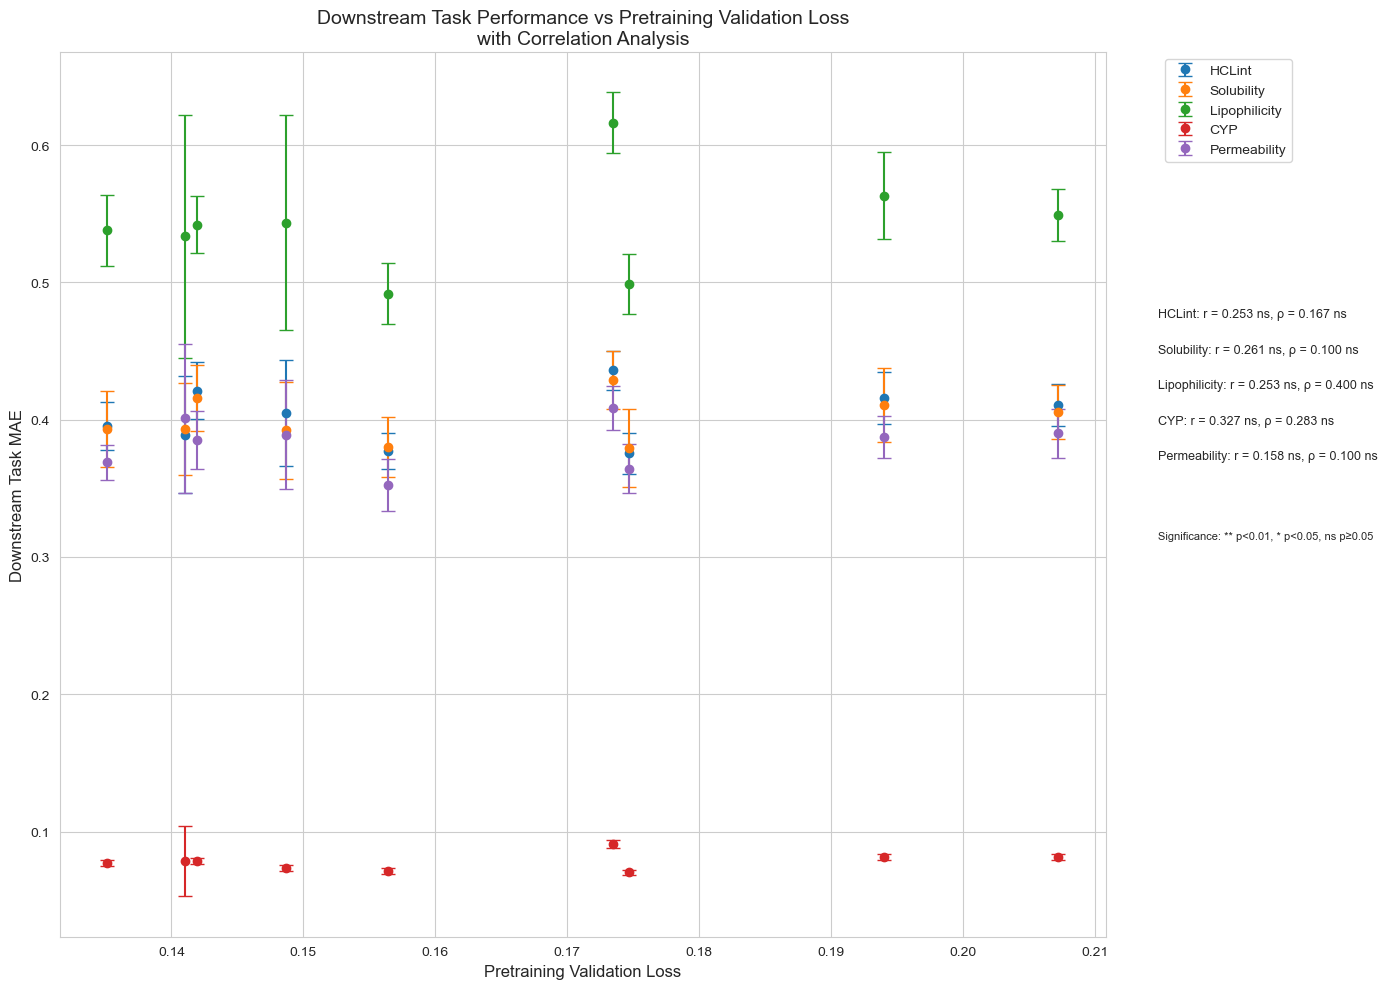

In [15]:
# Extract validation metrics
validation_metrics = extract_validation_metrics()
print("\nExtracted validation metrics:")
print(validation_metrics)

# Extract cross-validation metrics
cross_val_metrics = extract_cross_val_metrics()
print("\nExtracted cross-validation metrics:")
print(cross_val_metrics)

# Calculate correlations for each evaluation dataset
print("\n" + "="*60)
print("CORRELATION ANALYSIS: Pretraining Loss vs Downstream Performance")
print("="*60)
correlation_df, merged_df = calculate_correlations(validation_metrics, cross_val_metrics)

# Display correlation summary table
print("\n" + "="*60)
print("CORRELATION SUMMARY TABLE")
print("="*60)
print(correlation_df.round(4))

# Create scatter plot
create_scatter_plot(validation_metrics, cross_val_metrics)